# Visualiasis eDNA P1 Pandeglang


## Membaca hasil dari data csv
Pertama-tama, load library numpy, pandas, matplolib, seaborn dan plotly


In [62]:
#example kayak ini bisa digunakan untuk membuat visualisasi data dengan berbagai library di Python
# contoh ini menggunakan beberapa library populer untuk visualisasi data
# seperti matplotlib, seaborn, dan plotly.
# pastikan kamu sudah menginstall library tersebut sebelum menjalankan kode ini

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import csv
import os

# bagi yang belum install seaborn, bisa install dulu dengan perintah:
# pip install matplotlib
# pip install pandas
# pip install numpy
# pip install seaborn
# pip install plotly

# Disini Kita Akan Mulai Pembuatan Krona Dahulu

In [63]:
import pandas as pd
import plotly.express as px
import seaborn as sns  # Tambahkan seaborn
import os

# 1. Load Data
df = pd.read_csv('eDNA no filter.csv', sep=';')

# 2. Preprocess Data - Auto Sum untuk taxa yang sama
hierarchy = ['superkingdom', 'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'Species']
df_aggregated = df.groupby(hierarchy)['Total Magnitude'].sum().reset_index()

# 3. Ambil palet warna dari seaborn 'husl'
unique_species = df_aggregated['Species'].nunique()
colors = sns.color_palette('husl', n_colors=unique_species).as_hex()

# 4. Buat Sunburst Plot dengan warna dari seaborn
fig = px.sunburst(
    df_aggregated,
    path=hierarchy,
    values='Total Magnitude',
    color='Species',
    color_discrete_sequence=colors,  # Gunakan palet warna husl
    title='Sunburst Plot of eDNA Data (Krona-like)',
    width=1000,
    height=1000,
    branchvalues='total',
    maxdepth=5
)

# 5. Customize
fig.update_traces(
    textinfo="label+percent parent+value",
    insidetextorientation='radial',
    hovertemplate='<b>%{label}</b><br>Total Magnitude: %{value:,}<br>%{percentParent:.1%} of parent<br>Hierarchy: %{id}',
    textfont=dict(size=12)
)

fig.update_layout(
    margin=dict(t=50, l=0, r=0, b=0),
    title_font=dict(size=20)
)

# 6. Show & Save
os.makedirs('results', exist_ok=True)
fig.write_html(os.path.join('results', 'krona_like_sunburst.html'))
fig.show()


## Pembuatan Pohon Sankey


In [64]:
import pandas as pd
import plotly.graph_objects as go
import os
import random

# Read and preprocess the data
df = pd.read_csv('eDNA no filter.csv', sep=';', header=None, 
                 names=['Domain', 'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Count'])

# Clean the data
df = df.dropna()
df['Count'] = pd.to_numeric(df['Count'], errors='coerce')
df = df.dropna(subset=['Count'])
df = df[df['Count'] > 0]

# Aggregate counts for each taxonomic level
def aggregate_data(df, levels):
    return df.groupby(levels)['Count'].sum().reset_index()

# Prepare data for Sankey diagram
def prepare_sankey_data(df):
    # Define all taxonomic levels
    levels = ['Domain', 'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus']
    
    # Create source-target pairs for each level
    sources = []
    targets = []
    values = []
    labels = []
    label_dict = {}
    
    # Create mapping from label to index
    current_id = 0
    for i in range(len(levels)-1):
        grouped = aggregate_data(df, levels[:i+2])
        for _, row in grouped.iterrows():
            # Add parent label (current level)
            parent_label = str(row[levels[i]])
            if parent_label not in label_dict:
                label_dict[parent_label] = current_id
                labels.append(parent_label)
                current_id += 1
            
            # Add child label (next level)
            child_label = str(row[levels[i+1]])
            if child_label not in label_dict:
                label_dict[child_label] = current_id
                labels.append(child_label)
                current_id += 1
            
            # Add link
            sources.append(label_dict[parent_label])
            targets.append(label_dict[child_label])
            values.append(row['Count'])
    
    return sources, targets, values, labels

# Generate Sankey data
sources, targets, values, labels = prepare_sankey_data(df)

# Generate random colors for nodes
def generate_colors(n):
    colors = []
    for _ in range(n):
        # Generate bright, vibrant colors
        r = random.randint(100, 255)
        g = random.randint(100, 255)
        b = random.randint(100, 255)
        colors.append(f"rgb({r},{g},{b})")
    return colors

node_colors = generate_colors(len(labels))

# Create gradient colors for links based on source nodes
link_colors = []
for src in sources:
    base_color = node_colors[src]
    # Make link color slightly transparent
    link_colors.append(base_color.replace('rgb', 'rgba').replace(')', ',0.4)'))

# Create the Sankey diagram
fig = go.Figure(go.Sankey(
    arrangement="snap",
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=node_colors  # Warna-warni untuk node
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=link_colors  # Warna link sesuai dengan node sumber
    )
))

# Update layout with better font settings
fig.update_layout(
    title_text="Taxonomic Classification Flow (eDNA Data) - Colorful Version",
    font=dict(
        size=12,
        family="Arial"
    ),
    height=1200,
    width=1400
)

# Save and show
os.makedirs('results', exist_ok=True)
fig.write_html(os.path.join('results', 'taxonomic_sankey_colorful.html'))
fig.show()


## Disini kita akan mencoba mendeteksi Species Indikator

Bioindikator yang ditemukan dalam dataset:
            Matched Pattern  Total Magnitude
2              Euglena spp.             8445
0        Aelosoma hemprichi              655
3  Limnodrilus hoffmeisteri              355
1        Enchytraeidae spp.              235
4             Planaria spp.               20


/tmp/ipykernel_356400/1773569189.py:80: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




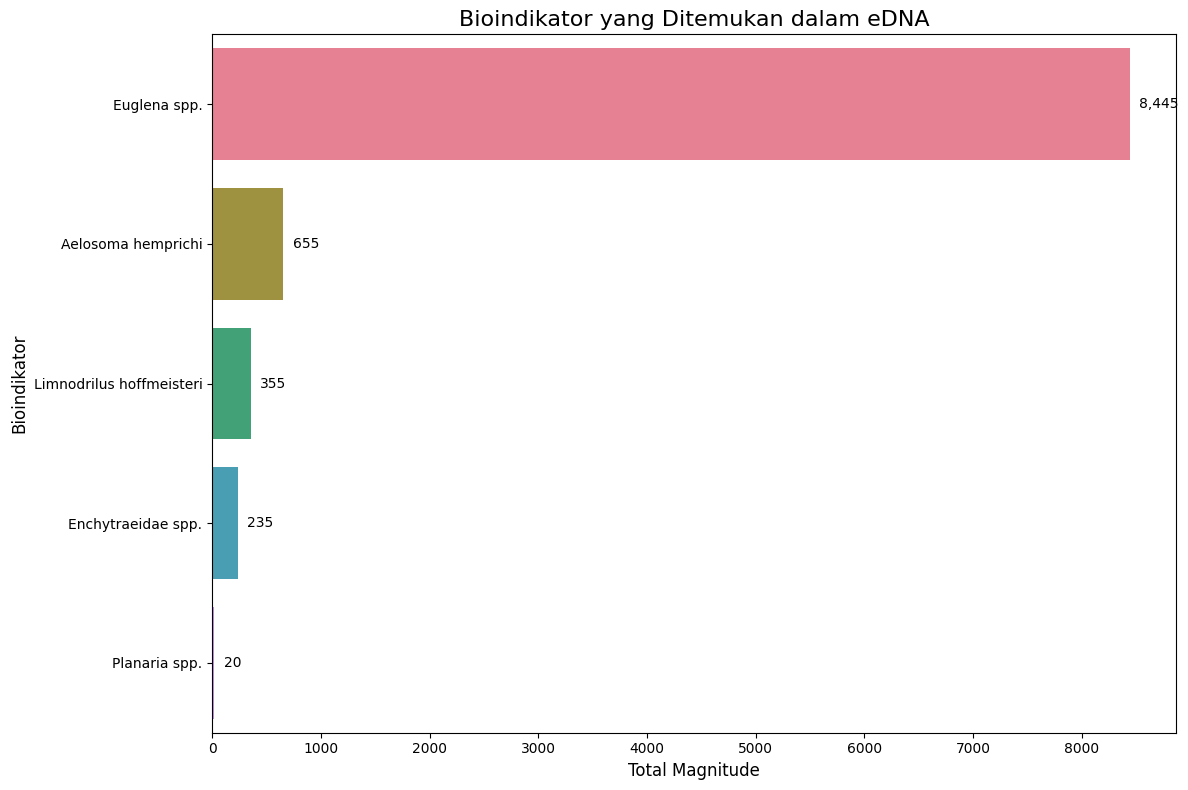

In [71]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os

# Daftar bioindikator yang ingin dideteksi
bioindicators = [
    "Aelosoma hemprichi", "Enchytraeidae spp.", "Planaria spp.", 
    "Limnodrilus hoffmeisteri", "Nais elinguis", "Corbicula fluminea", 
    "Melanoides tuberculata", "Helisoma trivolvis", "Viviparus viviparus", 
    "Gammarus pulex", "Eucyclops serrulatus", "Bosmina longirostris", 
    "Cyclops vicinus", "Calanus finmarchicus", "Acanthocyclops vernalis", 
    "Keratella cochlearis", "Lecane spp.", "Synchaeta spp.", 
    "Paramecium caudatum", "Euglena spp.", "Ankistrodesmus falcatus", 
    "Scenedesmus quadricauda", "Pediastrum duplex", "Chlorella vulgaris", 
    "Chlamydomonas reinhardtii", "Dinobryon spp.", "Fragilaria crotonensis", 
    "Cyclotella meneghiniana", "Asterionella formosa", "Tabellaria flocculosa", 
    "Melosira spp.", "Gomphonema spp.", "Pinnularia spp.", "Surirella spp.", 
    "Synedra ulna", "Stephanodiscus hantzschii", "Spirogyra spp.", 
    "Vaucheria spp.", "Ulothrix spp.", "Tribonema spp.", "Hydrilla verticillata", 
    "Vallisneria spiralis", "Potamogeton crispus", "Najas marina", 
    "Sagittaria spp.", "Typha angustifolia", "Phragmites australis", 
    "Scirpus spp.", "Juncus effusus", "Cyperus spp.", "Salvinia molesta", 
    "Azolla pinnata", "Wolffia globosa", "Isoetes lacustris", 
    "Eriocaulon aquaticum", "Acorus calamus", "Eleocharis spp.", 
    "Ludwigia peploides", "Limnophila sessiliflora", "Bacopa monnieri", 
    "Hygrophila polysperma", "Alternanthera philoxeroides", 
    "Neocloeon spp.", "Simulium spp.", "Caenis spp.", "Baetis rhodani"
]

# Membaca file CSV
df = pd.read_csv('eDNA no filter.csv', sep=';')

# Fungsi untuk mendeteksi bioindikator dalam dataframe
def detect_bioindicators(df, bio_list):
    results = []
    
    for bio in bio_list:
        if ' spp.' in bio:
            genus = bio.split()[0]
            pattern = re.compile(rf'\b{re.escape(genus)}\b', re.IGNORECASE)
        else:
            pattern = re.compile(rf'\b{re.escape(bio)}\b', re.IGNORECASE)
        
        species_matches = df[df['Species'].str.contains(pattern, na=False)]
        if not species_matches.empty:
            species_matches = species_matches.copy()
            species_matches['Matched Pattern'] = bio
            results.append(species_matches)
        
        genus_matches = df[df['genus'].str.contains(pattern, na=False)]
        if not genus_matches.empty:
            genus_matches = genus_matches.copy()
            genus_matches['Matched Pattern'] = bio
            results.append(genus_matches)
    
    if results:
        result_df = pd.concat(results).drop_duplicates()
        return result_df
    else:
        return pd.DataFrame()

# Mendeteksi bioindikator dalam data
bio_detected = detect_bioindicators(df, bioindicators)

# Menyimpan visualisasi ke folder 'results'
os.makedirs('results', exist_ok=True)

# Menampilkan dan menyimpan hasil deteksi
if not bio_detected.empty:
    print("Bioindikator yang ditemukan dalam dataset:")
    summary = bio_detected.groupby('Matched Pattern')['Total Magnitude'].sum().reset_index()
    summary = summary.sort_values('Total Magnitude', ascending=False)
    
    print(summary)
    
    # Visualisasi
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(
        x='Total Magnitude', 
        y='Matched Pattern', 
        data=summary, 
        palette='husl'
    )
    
    ax.set_title('Bioindikator yang Ditemukan dalam eDNA', fontsize=16)
    ax.set_xlabel('Total Magnitude', fontsize=12)
    ax.set_ylabel('Bioindikator', fontsize=12)
    
    for i, v in enumerate(summary['Total Magnitude']):
        ax.text(v + max(summary['Total Magnitude'])*0.01, i, f"{v:,}", color='black', va='center')
    
    plt.tight_layout()
    plt.savefig(os.path.join('results', 'bioindicator_abundance_plot.png'), bbox_inches='tight', dpi=300)
    plt.show()
    
    # Simpan hasil summary ke CSV
    summary.to_csv(os.path.join('results', 'bioindicator_summary.csv'), index=False)
else:
    print("Tidak ada bioindikator yang ditemukan dalam dataset.")


## Kemudian akan membuat Stacked Bar Plot untuk tiap Taxa


/tmp/ipykernel_356400/2714524926.py:52: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.



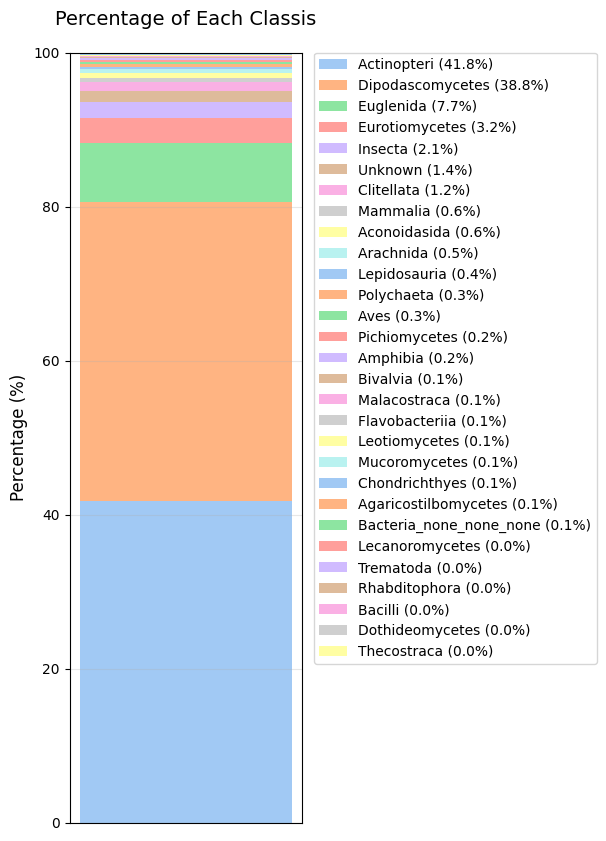

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Membaca data dari file CSV
data = pd.read_csv('1class.csv', sep=';', header=None, names=['Count', 'Class'])

# Menghitung total count untuk persentase
total = data['Count'].sum()

# Mengelompokkan data berdasarkan Class dan menjumlahkan count-nya
grouped = data.groupby('Class')['Count'].sum().reset_index()

# Menghitung persentase
grouped['Percentage'] = (grouped['Count'] / total) * 100

# Mengurutkan dari yang terbesar
grouped = grouped.sort_values('Percentage', ascending=False)

# Warna untuk setiap class (kita buat otomatis)
# Menggunakan palet pastel dari seaborn untuk warna yang lebih lembut dan menarik
colors = sns.color_palette("pastel", len(grouped))

# Membuat plot
plt.figure(figsize=(3, 10))

# Membuat stacked bar (hanya satu bar)
bottom = 0
for i, (class_name, percentage) in enumerate(zip(grouped['Class'], grouped['Percentage'])):
    plt.bar('class', percentage, bottom=bottom, color=colors[i], label=f'{class_name} ({percentage:.1f}%)')
    bottom += percentage

# Menambahkan judul dan label
plt.title('Percentage of Each Classis', fontsize=14, pad=20)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks([])  # Menghilangkan label x-axis karena hanya satu bar

# Menambahkan legenda di sebelah kanan
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Menetapkan batas y-axis
plt.ylim(0, 100)

# Menampilkan grid untuk memudahkan pembacaan
plt.grid(axis='y', alpha=0.3)

# Simpan hasil plot ke folder 'results'
os.makedirs('results', exist_ok=True)
plt.savefig(os.path.join('results', 'class_percentage_plot_full.png'), bbox_inches='tight', dpi=300)

# Menampilkan plot
plt.tight_layout()
plt.show()

/tmp/ipykernel_356400/3169095856.py:69: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.



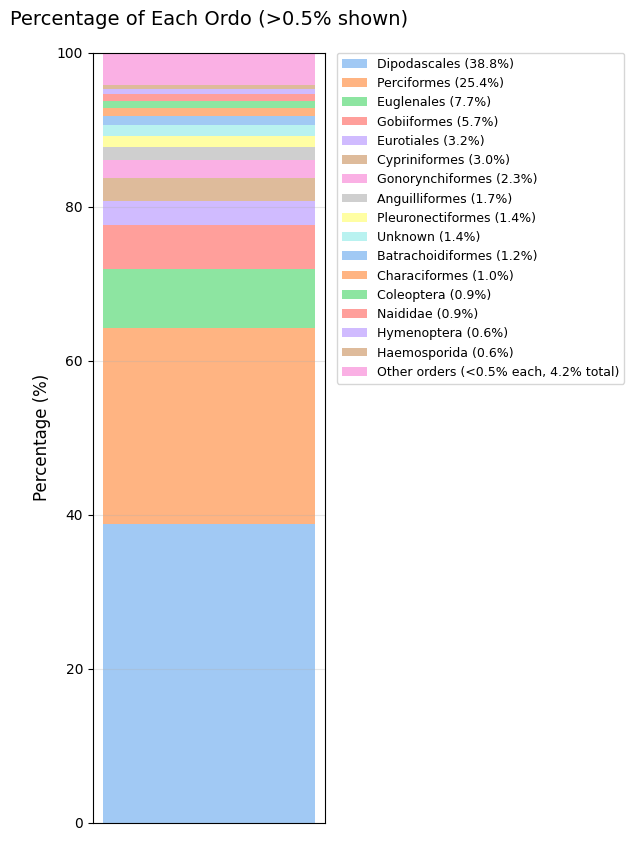

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Membaca data dari file CSV
data = pd.read_csv('2ordo.csv', sep=';', header=None, names=['Count', 'Order'])

# Pastikan kolom Count bertipe numerik
data['Count'] = pd.to_numeric(data['Count'], errors='coerce')

# Menghitung total count untuk persentase
total = data['Count'].sum()

# Mengelompokkan data berdasarkan Order dan menjumlahkan count-nya
grouped = data.groupby('Order')['Count'].sum().reset_index()

# Menghitung persentase
grouped['Percentage'] = (grouped['Count'] / total) * 100

# Mengurutkan dari yang terbesar
grouped = grouped.sort_values('Percentage', ascending=False)

# Filter hanya yang persentasenya > 0.5%
significant_orders = grouped[grouped['Percentage'] > 0.5]
other_orders = grouped[grouped['Percentage'] <= 0.5]

# Gabungkan yang kecil sebagai "Others"
others_percentage = other_orders['Percentage'].sum()
if others_percentage > 0:
    significant_orders = pd.concat([significant_orders, 
                                 pd.DataFrame({'Order': ['Others'], 
                                              'Count': [other_orders['Count'].sum()], 
                                              'Percentage': [others_percentage]})])

# Warna untuk setiap order
colors = sns.color_palette("pastel", len(significant_orders))

# Membuat plot
plt.figure(figsize=(3, 10))

# Membuat stacked bar (hanya satu bar)
bottom = 0
for i, (order_name, percentage) in enumerate(zip(significant_orders['Order'], significant_orders['Percentage'])):
    plt.bar('order', percentage, bottom=bottom, color=colors[i], 
            label=f'{order_name} ({percentage:.1f}%)' if order_name != 'Others' 
                  else f'Other orders (<0.5% each, {percentage:.1f}% total)')
    bottom += percentage

# Menambahkan judul dan label
plt.title('Percentage of Each Ordo (>0.5% shown)', fontsize=14, pad=20)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks([])  # Menghilangkan label x-axis karena hanya satu bar

# Menambahkan legenda di sebelah kanan
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=9)

# Menetapkan batas y-axis
plt.ylim(0, 100)

# Menampilkan grid untuk memudahkan pembacaan
plt.grid(axis='y', alpha=0.3)

# Simpan hasil plot ke folder 'results'
os.makedirs('results', exist_ok=True)
plt.savefig(os.path.join('results', 'ordo_percentage_plot_full.png'), bbox_inches='tight', dpi=300)

# Menampilkan plot
plt.tight_layout()
plt.show()


/tmp/ipykernel_356400/3085041226.py:73: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.



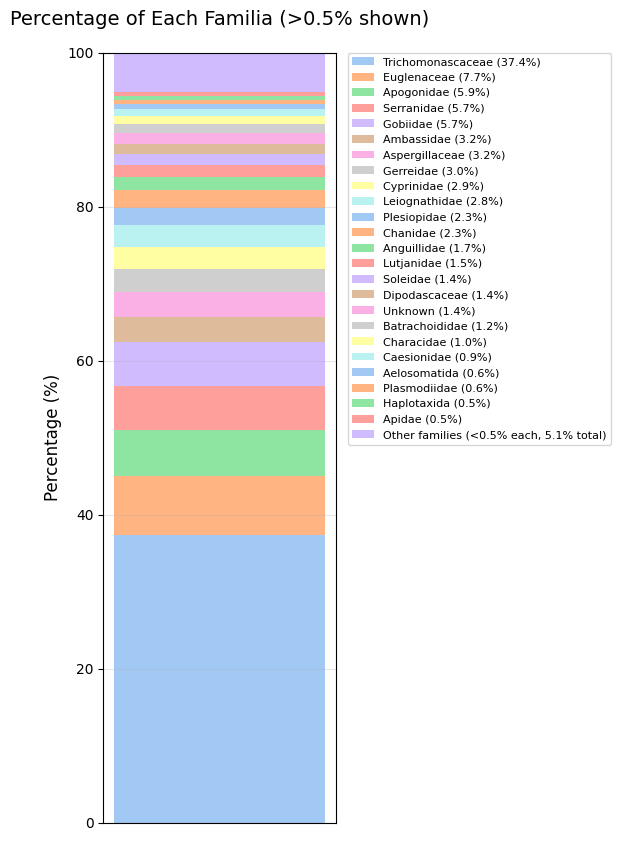

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

# Membaca data dari file CSV
data = pd.read_csv('3family.csv', sep=';', header=None, names=['Count', 'Family'])

# Pastikan kolom Count bertipe numerik
data['Count'] = pd.to_numeric(data['Count'], errors='coerce')

# Menghitung total count untuk persentase
total = data['Count'].sum()

# Mengelompokkan data berdasarkan Family dan menjumlahkan count-nya
grouped = data.groupby('Family')['Count'].sum().reset_index()

# Menghitung persentase
grouped['Percentage'] = (grouped['Count'] / total) * 100

# Mengurutkan dari yang terbesar
grouped = grouped.sort_values('Percentage', ascending=False)

# Pisahkan data menjadi yang >0.5% dan <=0.5%
significant_families = grouped[grouped['Percentage'] > 0.5]
other_families = grouped[grouped['Percentage'] <= 0.5]

# Gabungkan yang kecil sebagai "Others"
others_percentage = other_families['Percentage'].sum()
if others_percentage > 0:
    significant_families = pd.concat([significant_families, 
                                   pd.DataFrame({'Family': ['Others'], 
                                                'Count': [other_families['Count'].sum()], 
                                                'Percentage': [others_percentage]})])

# Warna untuk setiap family
colors = sns.color_palette("pastel", len(significant_families))

# Membuat plot dengan ukuran lebih besar untuk menampung lebih banyak kategori
plt.figure(figsize=(3, 10))

# Membuat stacked bar (hanya satu bar)
bottom = 0
for i, (family_name, percentage) in enumerate(zip(significant_families['Family'], significant_families['Percentage'])):
    if family_name == 'Others':
        label = f'Other families (<0.5% each, {percentage:.1f}% total)'
    else:
        label = f'{family_name} ({percentage:.1f}%)'
    
    plt.bar('family', percentage, bottom=bottom, color=colors[i], label=label)
    bottom += percentage

# Menambahkan judul dan label
plt.title('Percentage of Each Familia (>0.5% shown)', fontsize=14, pad=20)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks([])  # Menghilangkan label x-axis karena hanya satu bar

# Menambahkan legenda di sebelah kanan dengan font lebih kecil
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=8)

# Menetapkan batas y-axis
plt.ylim(0, 100)

# Menampilkan grid untuk memudahkan pembacaan
plt.grid(axis='y', alpha=0.3)

# Simpan hasil plot
os.makedirs('results', exist_ok=True)
plt.savefig(os.path.join('results', 'family_percentage_plot_filtered.png'), bbox_inches='tight', dpi=300)

# Menampilkan plot
plt.tight_layout()
plt.show()

/tmp/ipykernel_356400/890715545.py:73: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.



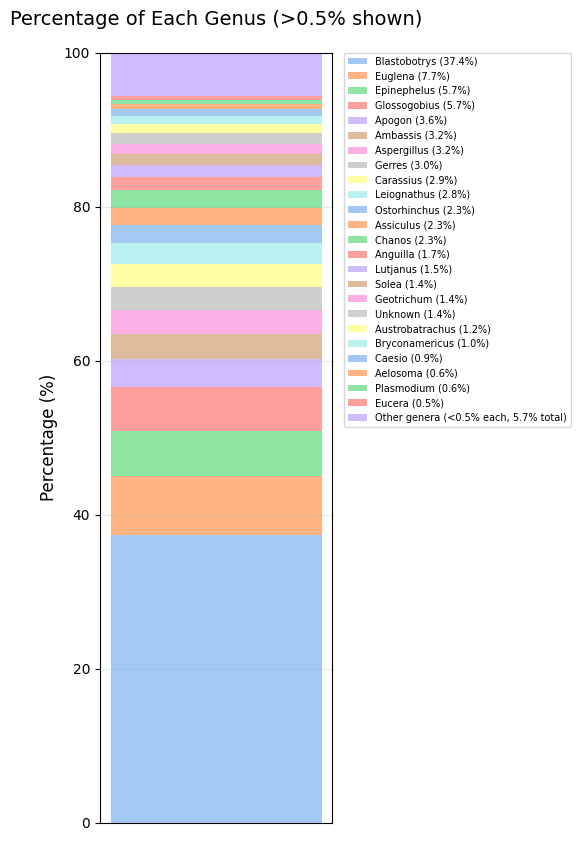

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

# Membaca data dari file CSV
data = pd.read_csv('4genus.csv', sep=';', header=None, names=['Count', 'Genus'])

# Pastikan kolom Count bertipe numerik
data['Count'] = pd.to_numeric(data['Count'], errors='coerce')

# Menghitung total count untuk persentase
total = data['Count'].sum()

# Mengelompokkan data berdasarkan Genus dan menjumlahkan count-nya
grouped = data.groupby('Genus')['Count'].sum().reset_index()

# Menghitung persentase
grouped['Percentage'] = (grouped['Count'] / total) * 100

# Mengurutkan dari yang terbesar
grouped = grouped.sort_values('Percentage', ascending=False)

# Pisahkan data menjadi yang >0.5% dan <=0.5%
significant_genera = grouped[grouped['Percentage'] > 0.5]
other_genera = grouped[grouped['Percentage'] <= 0.5]

# Gabungkan yang kecil sebagai "Others"
others_percentage = other_genera['Percentage'].sum()
if others_percentage > 0:
    significant_genera = pd.concat([significant_genera, 
                                 pd.DataFrame({'Genus': ['Others'], 
                                              'Count': [other_genera['Count'].sum()], 
                                              'Percentage': [others_percentage]})])

# Warna untuk setiap genus
colors = sns.color_palette("pastel", len(significant_genera))

# Membuat plot dengan ukuran lebih besar untuk menampung banyak kategori
plt.figure(figsize=(3, 10))  # Lebar diperbesar untuk nama genus yang panjang

# Membuat stacked bar (hanya satu bar)
bottom = 0
for i, (genus_name, percentage) in enumerate(zip(significant_genera['Genus'], significant_genera['Percentage'])):
    if genus_name == 'Others':
        label = f'Other genera (<0.5% each, {percentage:.1f}% total)'
    else:
        label = f'{genus_name} ({percentage:.1f}%)'
    
    plt.bar('genus', percentage, bottom=bottom, color=colors[i], label=label)
    bottom += percentage

# Menambahkan judul dan label
plt.title('Percentage of Each Genus (>0.5% shown)', fontsize=14, pad=20)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks([])  # Menghilangkan label x-axis karena hanya satu bar

# Menambahkan legenda di sebelah kanan dengan font lebih kecil
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=7)  # Font size diperkecil

# Menetapkan batas y-axis
plt.ylim(0, 100)

# Menampilkan grid untuk memudahkan pembacaan
plt.grid(axis='y', alpha=0.3)

# Simpan hasil plot
os.makedirs('results', exist_ok=True)
plt.savefig(os.path.join('results', 'genus_percentage_plot_filtered.png'), bbox_inches='tight', dpi=300)

# Menampilkan plot
plt.tight_layout()
plt.show()

## PEMBUATAN 5 TERBESAR by BAR CHART


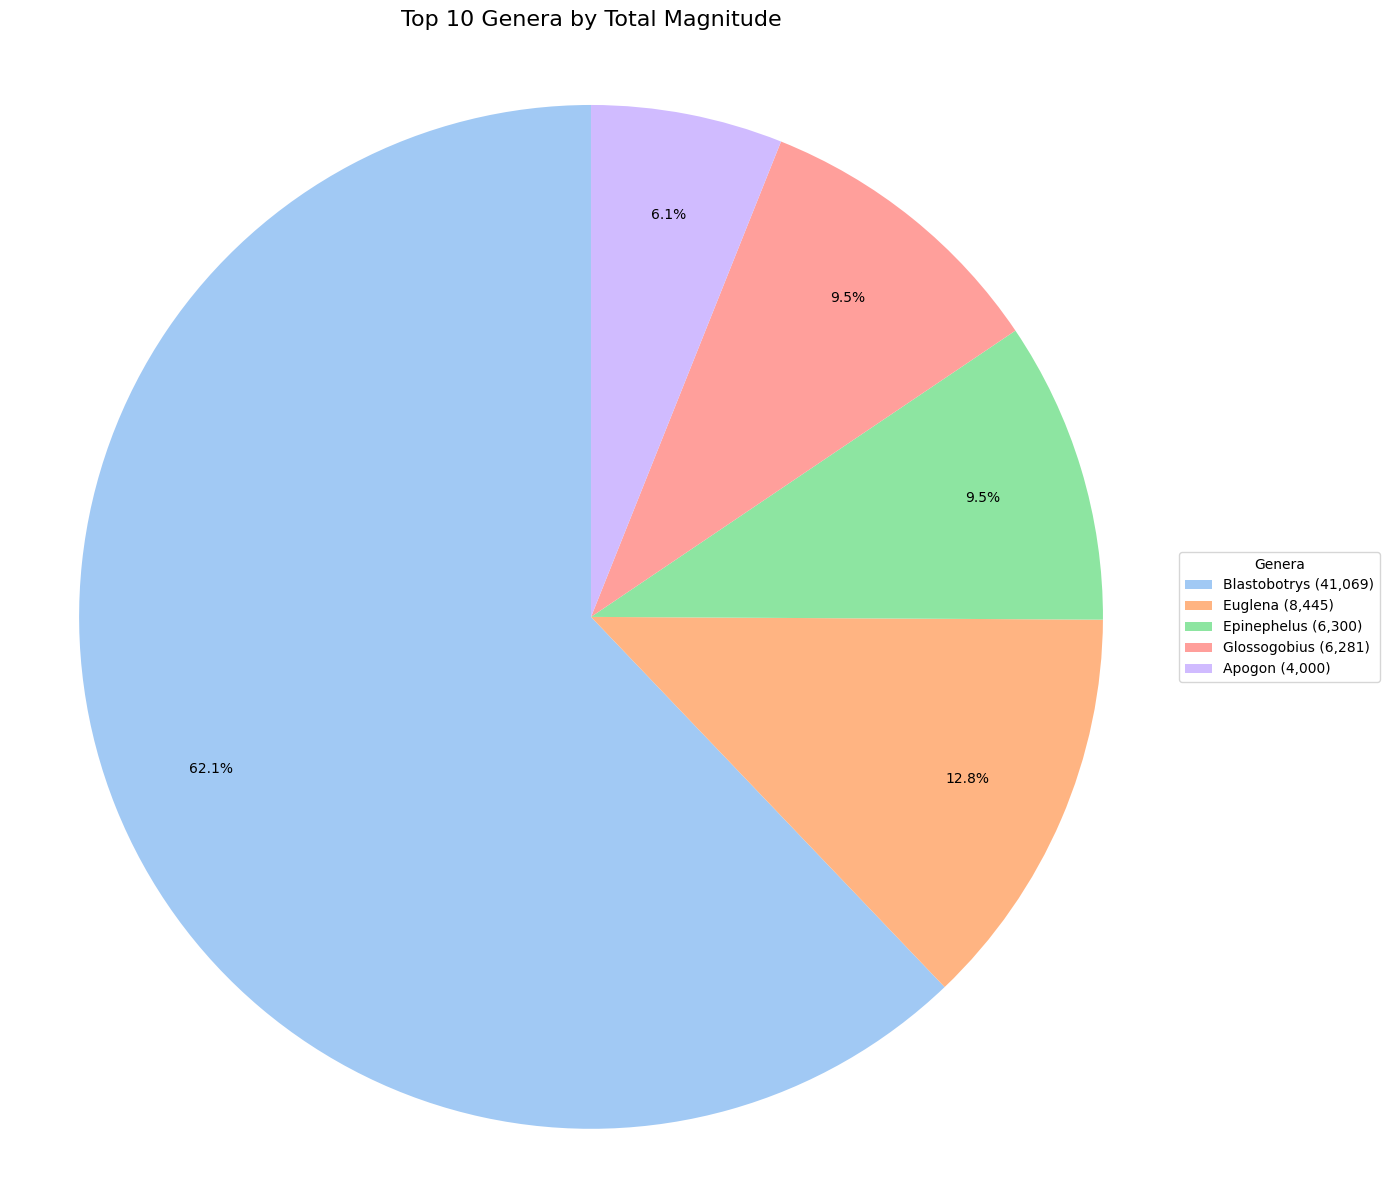

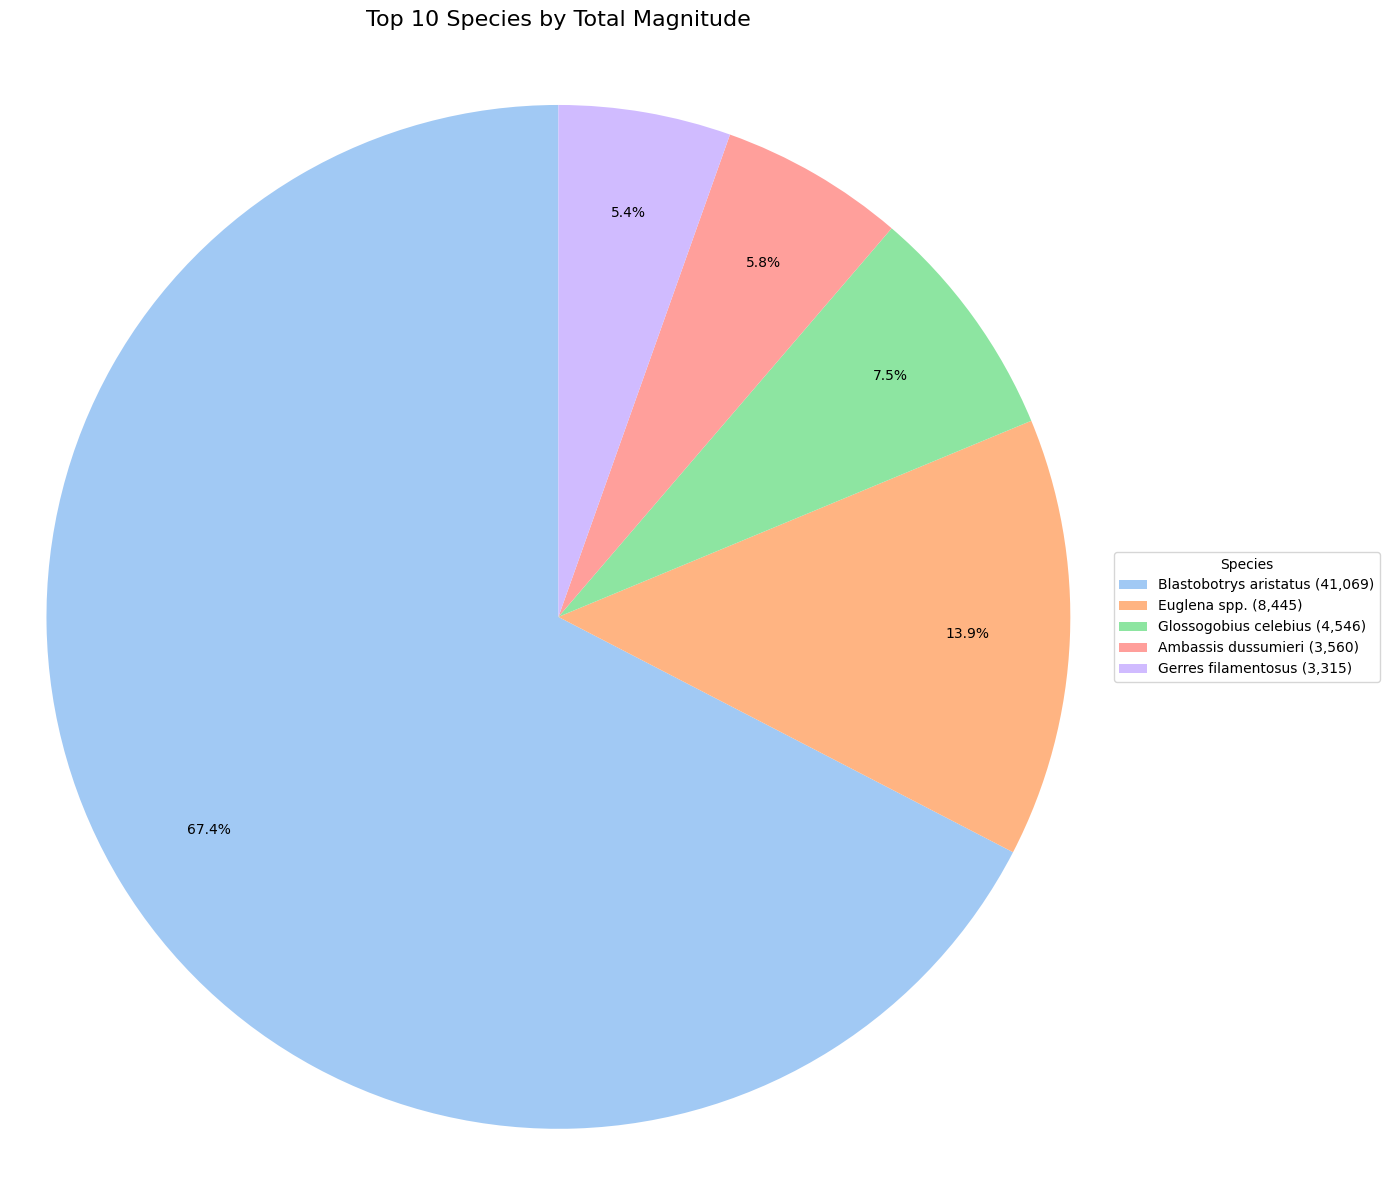

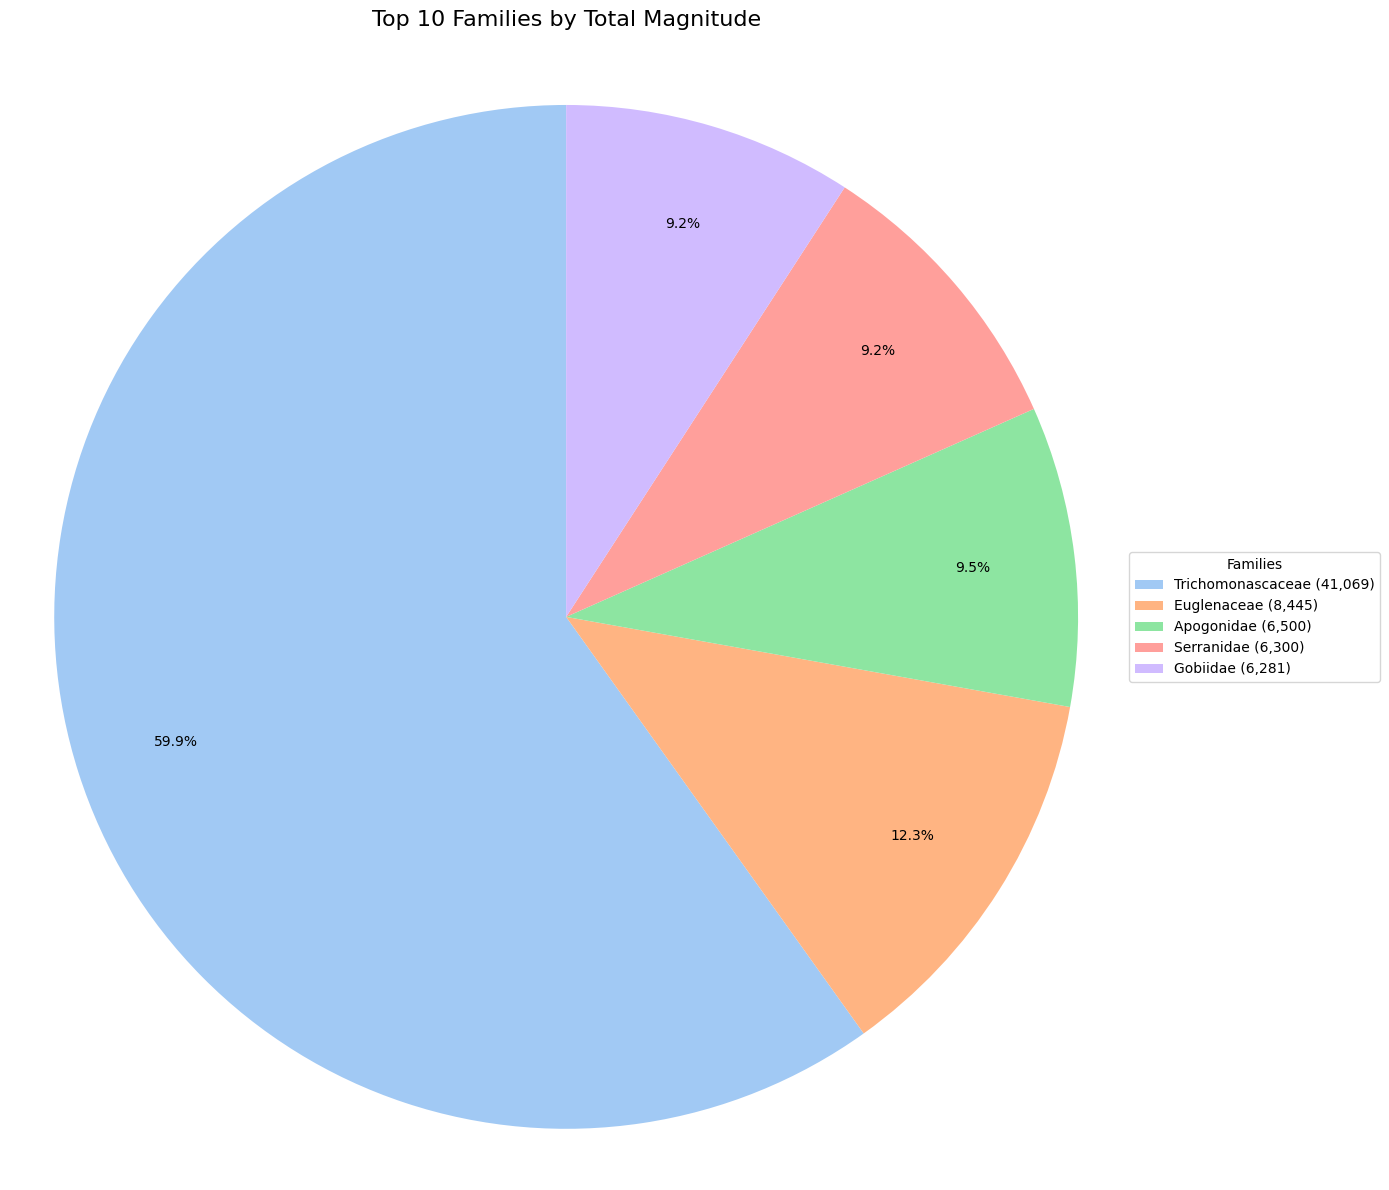

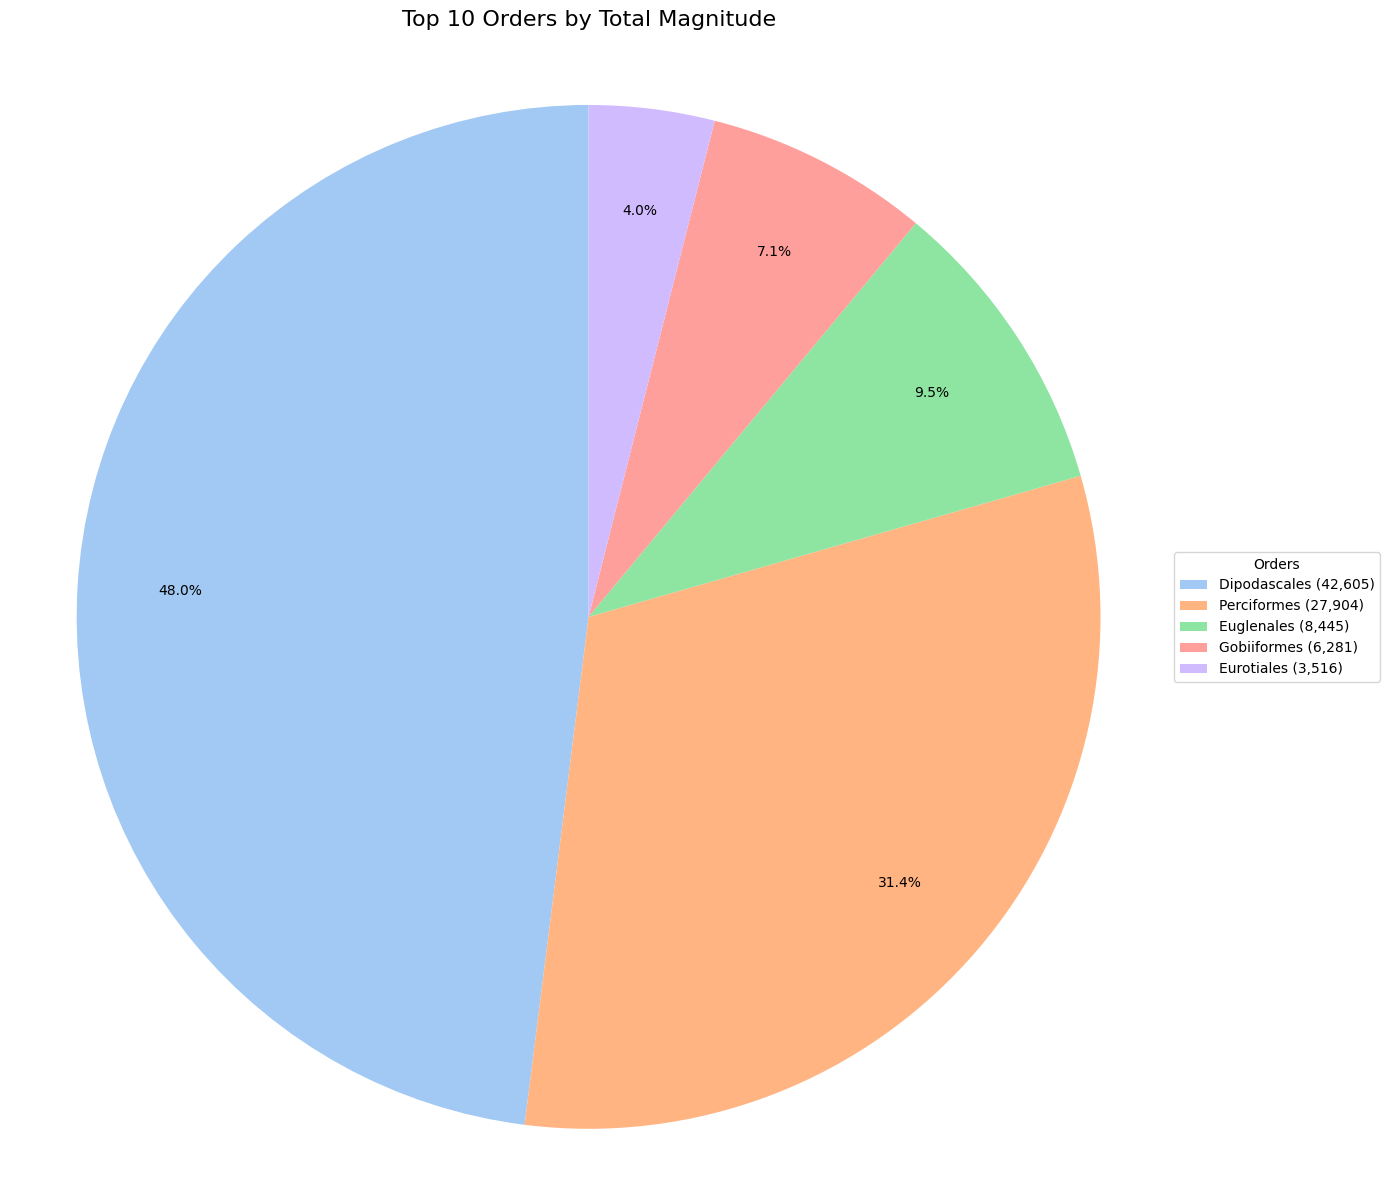

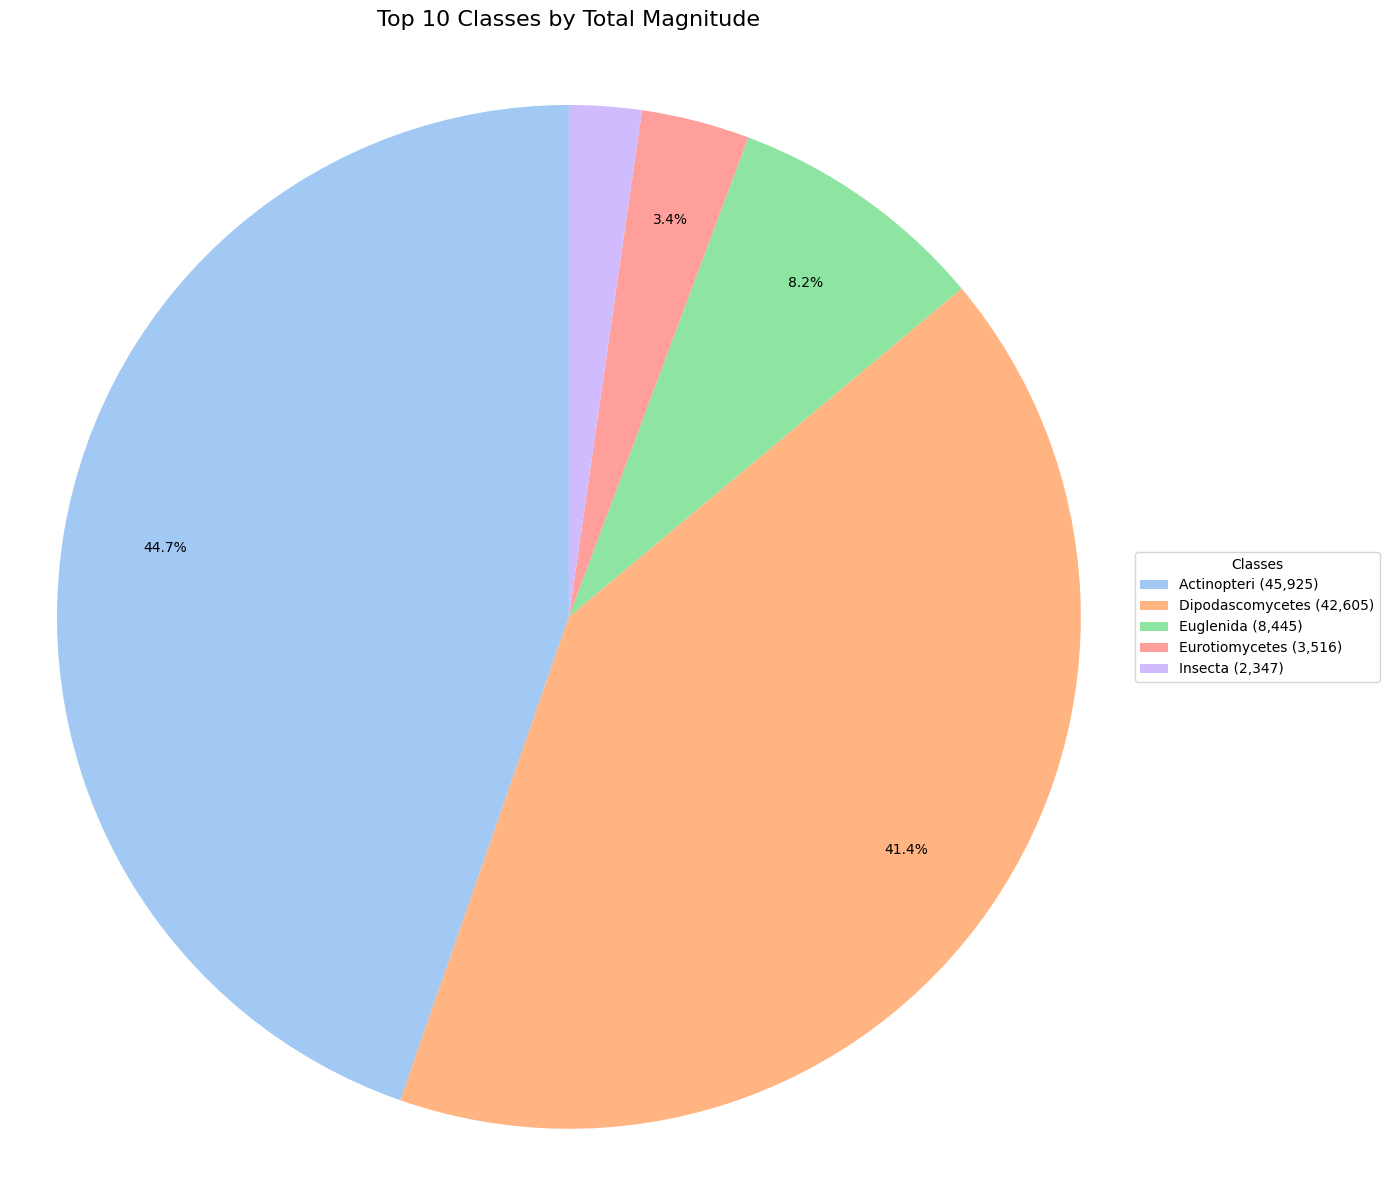

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Read and clean the data
df = pd.read_csv('eDNA no filter.csv', sep=';')
df['Total Magnitude'] = pd.to_numeric(df['Total Magnitude'], errors='coerce')
df = df.dropna(subset=['Total Magnitude'])
df = df[df['Total Magnitude'] > 0]

# Create pastel color palette
pastel_colors = sns.color_palette("pastel")

# Function to create full pie chart with pastel colors and legend
def create_pie_chart(data, level, title, filename):
    # Get top 10
    top5 = data.groupby(level)['Total Magnitude'].sum().nlargest(5).reset_index()
    
    # Create figure with larger size to accommodate legend
    plt.figure(figsize=(14, 12))
    
    # Create pie chart with pastel colors
    wedges, texts, autotexts = plt.pie(top5['Total Magnitude'], 
                                      labels=None,  # We'll use legend instead
                                      autopct=lambda p: f'{p:.1f}%' if p >= 3 else '',
                                      startangle=90,
                                      pctdistance=0.8,
                                      colors=pastel_colors,
                                      textprops={'fontsize': 10})
    
    # Equal aspect ratio ensures pie is drawn as circle
    plt.axis('equal')
    plt.title(f'Top 10 {title} by Total Magnitude', fontsize=16, pad=20)
    
    # Create legend with percentage and absolute value
    legend_labels = [f"{row[level]} ({row['Total Magnitude']:,})" 
                    for _, row in top5.iterrows()]
    
    # Position legend to the right of the pie chart
    plt.legend(wedges, legend_labels,
              title=title,
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1),
              fontsize=10)
    
    # Adjust layout to prevent legend cutoff
    plt.tight_layout()
    
    # Save and show
    os.makedirs('results', exist_ok=True)
    plt.savefig(f'results/{filename}.png', bbox_inches='tight', dpi=300, transparent=True)
    plt.show()

# Create charts for each taxonomic level
create_pie_chart(df, 'genus', 'Genera', 'top5_genus')
create_pie_chart(df, 'Species', 'Species', 'top5_species')
create_pie_chart(df, 'family', 'Families', 'top5_family')
create_pie_chart(df, 'order', 'Orders', 'top5_order')
create_pie_chart(df, 'class', 'Classes', 'top5_class')